In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import os
import random
import optuna
import plotly
import joblib

from functions.parse_data import synth_dataloader
from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from cot_train.utils import MLP5



/tmp/ipykernel_299336/1840648749.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-27 12:07:23.668548: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 12:07:23.704058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 12:0

In [3]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)
device = tensor.device

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [24]:
#Load data and inspect
df = synth_dataloader('SMHIdata')
df.head(10)

#Set columns for X and y (input/output features)
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Sun_Zenith_Angle']
y_cols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
          'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']

#Find X and y
X=df[X_cols]
y=df[y_cols]

#Separate testdata from rest for 80/10/10 Train/Val/Test split
X_trainval, X_test, y_trainval, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

#Add noise to X_test, 0 mean with stdev equal to 3% of mean of each feature
np.random.seed(313)
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X.to_numpy(),axis=0)*0.03

#Set up which quantiles to estimate, and find index of estimator (q=0.5)
quantiles=np.array([0.1,0.5,0.9])
est= np.where(quantiles==0.5)[0].item()

In [25]:
val_size=0.1
num_models=1 #Set number of models in ensemble
nepochs=1000

lr=0.003
noise_ratio = 0.03
early_break=True

#Already tested
hidd_n_layers = 6
n_nodes = 175

In [26]:
def objective(trial):
    batch_size = trial.suggest_int('hidd_n_layers',250,750,50)
    lr = trial.suggest_float('n_nodes',0.001,0.01)

    layers = []
    layers.append(nn.Linear(len(X_cols),n_nodes))
    layers.append(nn.ReLU())
    for i in range(hidd_n_layers):
        layers.append(nn.Linear(n_nodes,n_nodes))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(n_nodes, len(quantiles)*len(y_cols)))
    sequence = lambda: nn.Sequential(*layers)

    #Initalize models
    models = [QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]

    #Train models
    for i,model in enumerate(models):
        #Find new train/val splits for each model for robustness
        validation_indices=np.array(random.sample(range(len(X_trainval['Cloud_B02'])), int(len(X['Cloud_B02'])*val_size)))
        train_indices=[i for i in range(len(X_trainval['Cloud_B02'])) if np.any(validation_indices==i)==False]  
        #Fit model
        model.fit(X_trainval.to_numpy(),y_trainval.to_numpy(), 
            train_indices=train_indices, 
            validation_indices=validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break)
    
    #Test models
    preds_total=[]
    #Make predictions and evaluate
    for i,model in enumerate(models):
        preds = model.predict(X_test.to_numpy())
        #Keep track of ensemble prediction
        if i==0:
            preds_total=preds
        else:
            preds_total=preds_total+preds

    #Now do the same for ensemble predictions
    preds_total=preds_total/num_models

    mse=mean_squared_error(y_test.to_numpy(),preds_total[:,:,est])

    return mse
    


In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100)

Epoch 431


Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.14it/s]

Training loss [2.0365267] Validation loss [2.1031778]
Epoch 432



Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.08it/s]

Training loss [2.0344987] Validation loss [2.0881577]
Epoch 433



Batch number: 100%|██████████| 229/229 [00:00<00:00, 341.62it/s]

Training loss [2.026908] Validation loss [2.0869389]
Epoch 434



Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.25it/s]

Training loss [2.0440464] Validation loss [2.0689995]
Epoch 435



Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.74it/s]

Training loss [2.0315332] Validation loss [2.0732436]
Epoch 436



Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.80it/s]

Training loss [2.026151] Validation loss [2.075177]
Epoch 437



Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.61it/s]

Training loss [2.0258396] Validation loss [2.0749133]
Epoch 438



Batch number: 100%|██████████| 229/229 [00:00<00:00, 343.24it/s]

Training loss [2.036629] Validation loss [2.0530703]
Epoch 439



Batch number: 100%|██████████| 229/229 [00:00<00:00, 342.44it/s]

Training loss [2.0314243] Validation loss [2.0783858]



[I 2024-03-27 11:56:20,129] Trial 41 finished with value: 0.006770966503265998 and parameters: {'hidd_n_layers': 700, 'n_nodes': 0.0024540972221366556}. Best is trial 11 with value: 0.006651544188898501.
/tmp/ipykernel_292384/4035073055.py:2: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size = trial.suggest_int('hidd_n_layers',250,750,50)


---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 339
With validation loss: 2.049948215484619


In [ ]:
#Save study
os.makedirs('optuna',exist_ok=True)
joblib.dump(study, "optuna/teststudy.pkl")

['optuna/teststudy.pkl']

In [4]:
#Load study
study = joblib.load("optuna/teststudy.pkl")

In [5]:
trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.006715012065988281
Best hyperparameters: {'hidd_n_layers': 6, 'n_nodes': 175}


/tmp/ipykernel_299336/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

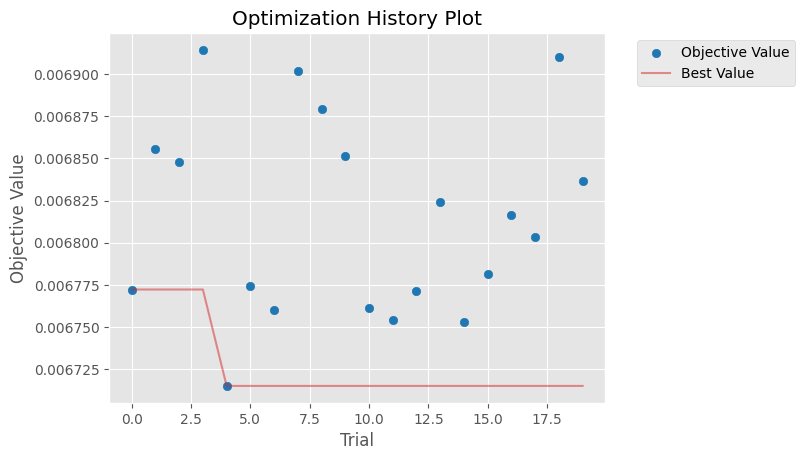

In [6]:
optuna.visualization.matplotlib.plot_optimization_history(study)

/tmp/ipykernel_299336/2375574420.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/home/edgelab/.local/lib/python3.10/site-packages/optuna/visualization/matplotlib/_slice.py:162: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim[0], xlim[1])


array([<Axes: xlabel='hidd_n_layers', ylabel='Objective Value'>,
       <Axes: xlabel='n_nodes'>], dtype=object)

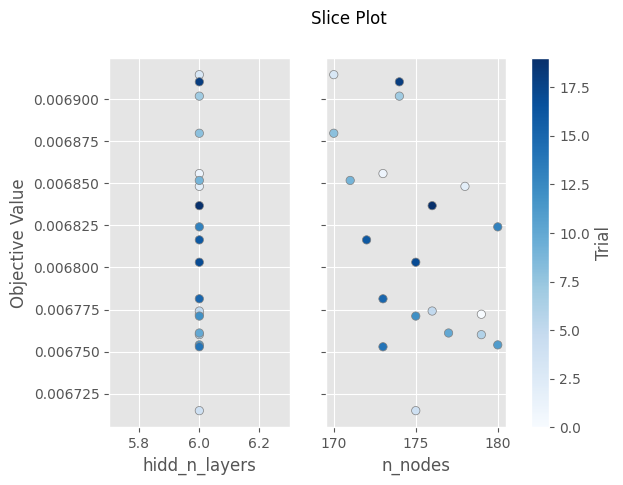

In [7]:
optuna.visualization.matplotlib.plot_slice(study)

/tmp/ipykernel_299336/2286643764.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["n_nodes", "hidd_n_layers"])
[W 2024-03-27 12:07:35,718] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2024-03-27 12:07:35,720] Param hidd_n_layers unique value length is less than 2.


<Axes: title={'center': 'Contour Plot'}>

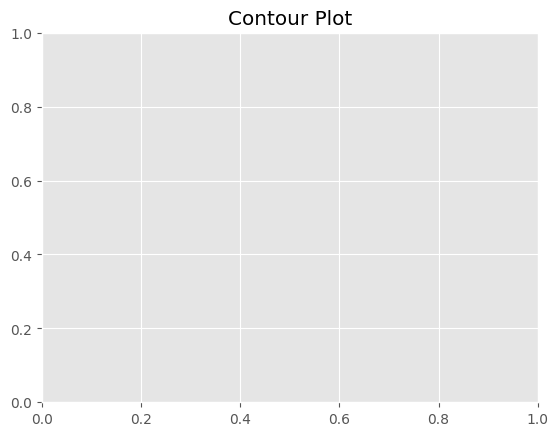

In [8]:
optuna.visualization.matplotlib.plot_contour(study, params=["n_nodes", "hidd_n_layers"])

/tmp/ipykernel_299336/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

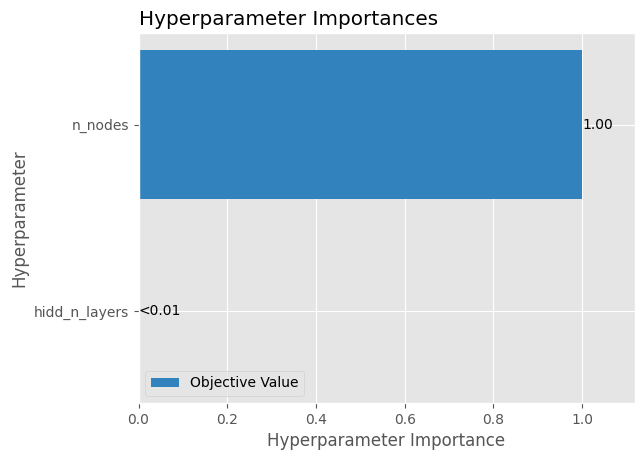

In [9]:
optuna.visualization.matplotlib.plot_param_importances(study)